In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109"
DATA_PATH = "/stored_data/jackal_one_frame"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)


trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = False
)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

[17:33:56] Saving checkpoints to:                                                                         ]8;id=595095;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=836692;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\
           outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109/nerfstudio_models                                

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109/nerfstudio_models/step-000009999.ckpt

In [5]:
z = 2.5
pitch = 0.785
r = -2.5
init_tf = np.eye(4)
init_tf[:3, :3] = Rotation.from_rotvec(np.array([pitch, 0, 0])).as_matrix()
init_tf[0, 3] = -r
init_tf[2, 3] = z
init_tf = [init_tf]*300

In [6]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [7]:
train_loop = 10
n = 100
lr_max = 5e-3
lr_min = 1e-4
store = torch.tensor([])

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))

store = torch.cat((store, torch.tensor([[0, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

for i in range(train_loop):
    for j in range(n):
        lr = lr_min + (lr_max - lr_min) * (i / train_loop)
        trainer.pipeline.train()
        loss, loss_dict, metrics_dict = trainer.train_iteration_inerf(i*n + j,optimizer_lr = 1e-4)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    
    store = torch.cat((store, torch.tensor([[i+1, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

Average translation error:  tensor(0.0889, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1233, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.0399, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1216, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.0320, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1294, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.0347, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1244, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.0385, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1220, device='cuda:0', d

In [8]:
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
rendered_img = get_image(trainer.pipeline, corrected_pose[0:,:,:])
rendered_img = rendered_img["rgb"]

Text(0.5, 1.0, 'Rendered image')

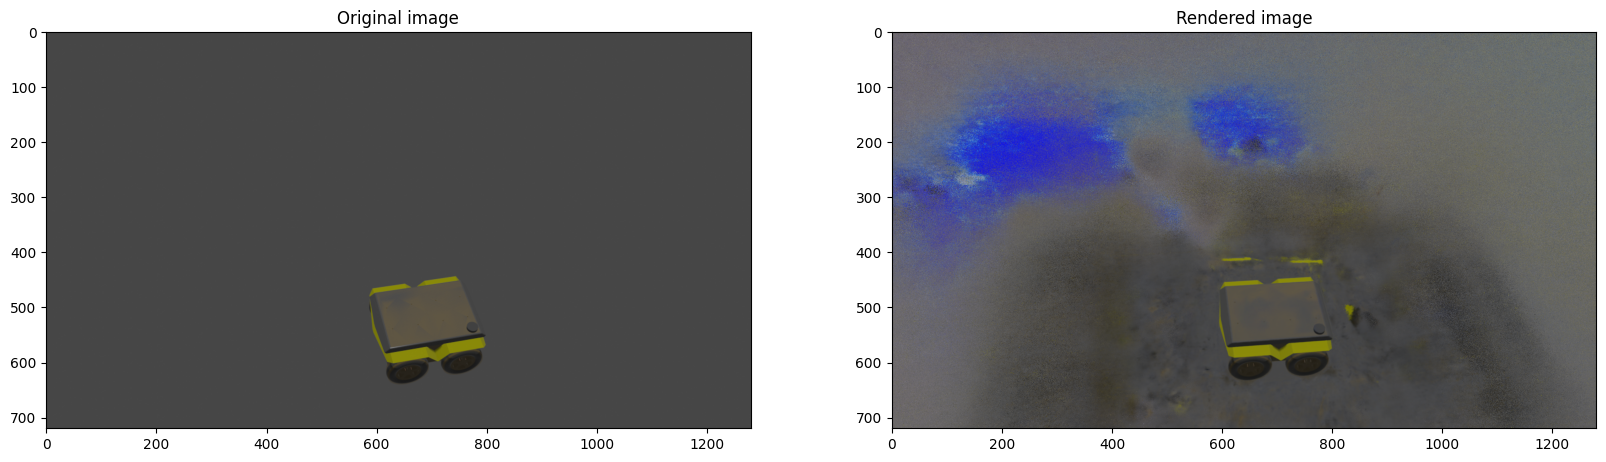

In [9]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(rendered_img)
ax[1].set_title("Rendered image")

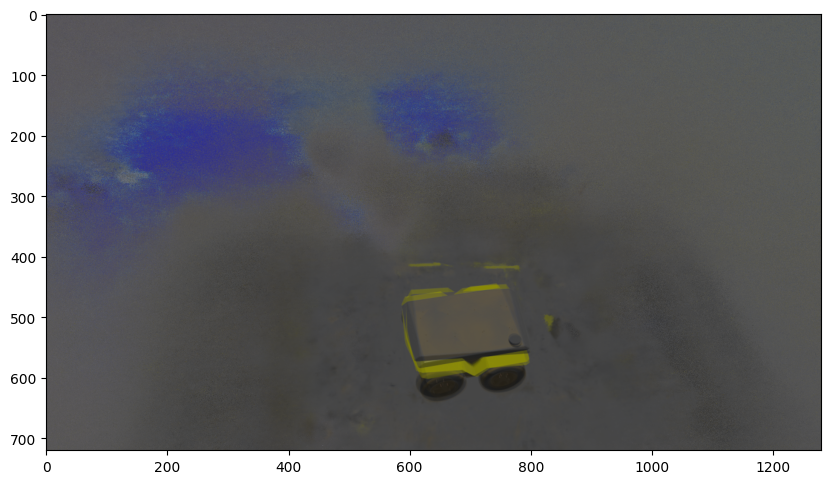

In [10]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(original_img)
ax.imshow(rendered_img, alpha=0.5)


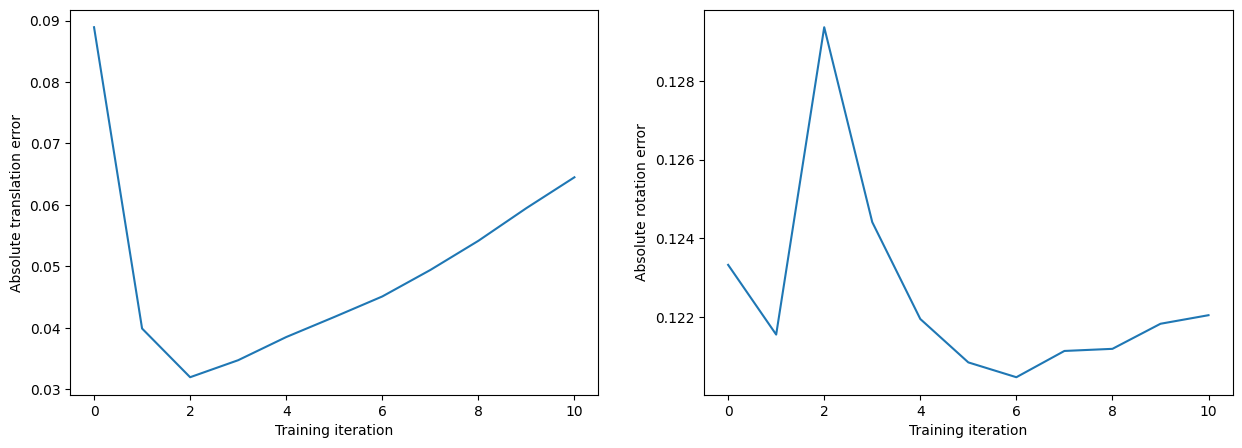

In [11]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots

plotting_data = np.asarray(store.to("cpu"))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(plotting_data[:, 0], plotting_data[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(plotting_data[:, 0], plotting_data[:, 2])
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()